In [ ]:
import os
import torch
import numpy as np
import typing as t
from torch import nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from skimage.transform import resize


from sensorium import data
from sensorium.models.model import Model
from sensorium.utils.scheduler import Scheduler
from sensorium.utils import utils, tensorboard, yaml
from sensorium.models.core.vit import ViTCore, Attention


utils.set_random_seed(1234)

GRAY = cm.get_cmap("gray")
BACKGROUND_COLOR = "#ffffff"

MOUSE_ID = 2
NUM_PLOTS = 5

Initialize model and load model checkpoint

In [ ]:
class Args:
    def __init__(self):
        self.output_dir = "/Users/bryanlimy/Git/sensorium/runs/sensorium+/055_vit_gaussian2d_0.2dropout_0.1coreReg"
        self.device = torch.device("cpu")
        self.batch_size = 1
        for key, value in yaml.load(os.path.join(self.output_dir, "args.yaml")).items():
            if not hasattr(self, key):
                setattr(self, key, value)
        self.dataset = os.path.join("..", self.dataset)


args = Args()

_, _, val_ds = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

model = Model(args, ds=val_ds)
model.train(False)

scheduler = Scheduler(args, model=model, save_optimizer=False)
scheduler.restore(force=True)

In [ ]:
class Recorder(nn.Module):
    def __init__(self, vit: ViTCore, device: str = "cpu"):
        super().__init__()
        self.vit = vit

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
        self.device = device

    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

    @staticmethod
    def _find_modules(nn_module, type):
        return [module for module in nn_module.modules() if isinstance(module, type)]

    def _register_hook(self):
        modules = self._find_modules(self.vit.transformer, Attention)
        for module in modules:
            handle = module.attend.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True

    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.vit

    def clear(self):
        self.recordings.clear()

    def record(self, attn):
        recording = attn.clone().detach()
        self.recordings.append(recording)

    def forward(self, images: torch.Tensor, behaviors: torch.Tensor):
        """Return attention output from ViT
        attns has shape (batch size, num blocks, num heads, patch size, patch size)
        """
        assert not self.ejected, "recorder has been ejected, cannot be used anymore"
        self.clear()
        if not self.hook_registered:
            self._register_hook()
        pred = self.vit(inputs=images, behaviors=behaviors)
        recordings = tuple(map(lambda t: t.to(self.device), self.recordings))
        attns = torch.stack(recordings, dim=1) if len(recordings) > 0 else None
        return pred, attns

In [ ]:
def plot_attention_map(
    rollouts: t.List[t.Tuple[np.ndarray, np.ndarray]], filename: str = None
):
    label_fontsize, tick_fontsize = 10, 8
    figure, axes = plt.subplots(
        nrows=len(rollouts),
        ncols=2,
        figsize=(8, 2 * len(rollouts)),
        gridspec_kw={"wspace": -0.25, "hspace": 0.1},
        dpi=120,
        facecolor=BACKGROUND_COLOR,
    )
    for i, (image, heatmap) in enumerate(rollouts):
        axes[i, 0].imshow(image[0], cmap="gray")
        axes[i, 1].imshow(heatmap[0], cmap="inferno")
        if i == 0:
            axes[i, 0].set_title("Input", fontsize=label_fontsize)
            axes[i, 1].set_title("Attention rollout", fontsize=label_fontsize)
        for ax in axes[i]:
            tensorboard.remove_spines(ax)
            ax.set_xticks([])
            ax.set_yticks([])

    # plot colorbar
    pos1 = axes[0, 1].get_position()
    pos2 = axes[-1, 1].get_position()
    width, height = 0.01, (pos1.y1 - pos1.y0) * 0.35
    cbar_ax = figure.add_axes(
        rect=[
            pos1.x1 + 0.01,
            ((pos1.y1 - pos2.y0) / 2 + pos2.y0) - (height / 2),
            width,
            height,
        ]
    )
    figure.colorbar(cm.ScalarMappable(cmap="inferno"), cax=cbar_ax, shrink=0.1)
    tensorboard.set_yticks(
        axis=cbar_ax,
        ticks_loc=np.linspace(0, 1, 3),
        tick_fontsize=tick_fontsize,
    )
    tensorboard.set_ticks_params(axis=cbar_ax)
    plt.show()
    if filename is not None:
        tensorboard.save_figure(figure, filename=filename, dpi=120)
        print(f"plot saved to {filename}.")

In [ ]:
def attention_rollout(results: t.List[t.Tuple[np.ndarray, np.ndarray]]):
    """
    Attention rollout from https://arxiv.org/abs/2005.00928
    Code examples
    - https://keras.io/examples/vision/probing_vits/#method-ii-attention-rollout
    - https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb
    """
    rollouts = []
    for image, attention in results:
        attention = np.mean(attention, axis=1)

        # to account for residual connections, we add an identity matrix to the
        # attention matrix and re-normalize the weights.
        residual_att = np.eye(attention.shape[1])
        aug_att_mat = attention + residual_att
        aug_att_mat = aug_att_mat / np.expand_dims(aug_att_mat.sum(axis=-1), axis=-1)

        # recursively multiply the weight matrices
        joint_attentions = np.zeros(aug_att_mat.shape)
        joint_attentions[0] = aug_att_mat[0]

        for n in range(1, aug_att_mat.shape[0]):
            joint_attentions[n] = np.matmul(aug_att_mat[n], joint_attentions[n - 1])

        mask = joint_attentions[-1, 0, 1:]
        mask = np.reshape(mask, newshape=(33, 61))
        mask = mask / np.max(mask)
        mask = resize(mask, output_shape=image.shape[1:])
        heatmap = mask * image
        rollouts.append((image.astype("uint8"), heatmap.astype("uint8")))
    return rollouts

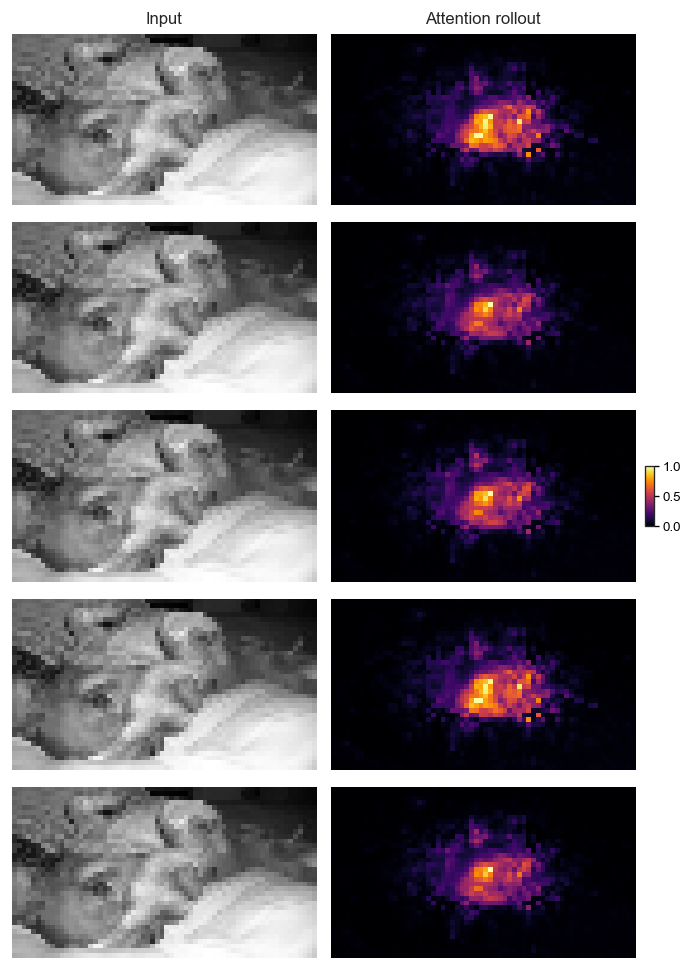

In [20]:
recorder = Recorder(model.core)

results = []  # list of image attention pairs
for batch in val_ds[MOUSE_ID]:
    with torch.no_grad():
        pupil_centers = batch["pupil_center"]
        # pupil_centers = torch.zeros_like(pupil_centers)
        behaviors = batch["behavior"]
        # behaviors = torch.zeros_like(behaviors)
        images, _ = model.image_cropper(
            inputs=batch["image"],
            mouse_id=MOUSE_ID,
            pupil_centers=pupil_centers,
            behaviors=behaviors,
        )
        _, attentions = recorder(images=images, behaviors=behaviors)
        images = val_ds[MOUSE_ID].dataset.i_transform_image(images)
        results.append((images.numpy()[0], attentions.numpy()[0]))
        recorder.clear()
    if len(results) == NUM_PLOTS:
        break

rollouts = attention_rollout(results=results)
plot_attention_map(
    rollouts=rollouts,
    # filename=os.path.join(args.output_dir, "plots", "attention_rollouts.pdf"),
)